In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import auc, roc_auc_score, accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression


In [175]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv'
#!python -m wget $data


In [176]:
credit_card_df = pd.read_csv('./AER_credit_card_data.csv')

In [177]:
credit_card_df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [178]:
#target variable

credit_card_df['card'] = credit_card_df['card'].replace({'yes':1, 'no':0}) 

In [179]:
credit_card_df.card.value_counts()

1    1023
0     296
Name: card, dtype: int64

In [180]:
#Splitting into train, validation and test data

fulltrain, test = train_test_split(credit_card_df,test_size=0.2, random_state=1)
train, val = train_test_split(fulltrain,test_size=0.25, random_state=1)

In [181]:
train.shape, val.shape, test.shape

((791, 12), (264, 12), (264, 12))

In [182]:
#numerical variables
numeric_columns = fulltrain.columns[(fulltrain.dtypes!='O') & (fulltrain.columns!='card')]

#categorical columns
categorical_columns = fulltrain.columns[fulltrain.dtypes=='O']

In [183]:
#checking feature importance using AUC

In [184]:
minmax_scaler = MinMaxScaler()
df_scaled = minmax_scaler.fit_transform(train[numeric_columns].to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=numeric_columns)

auc_dict = {}
for col in numeric_columns:
    auc_df = pd.DataFrame(list(zip(train['card'], df_scaled[col])), columns=['card', col])
    auc_df = auc_df.sort_values(by=col)
#     if auc_df.corr()['card'][col]<0:
#         auc_df[col]=-auc_df[col]
    auc_dict[col] = auc(auc_df[col], auc_df['card'])
    del auc_df
    

In [185]:
auc_dict

{'reports': 0.14285714285714285,
 'age': 0.7860002199143998,
 'income': 0.6769139123750959,
 'share': 0.9988696403481753,
 'expenditure': 0.9999318035208151,
 'dependents': 0.5833333333333334,
 'months': 0.6546296296296296,
 'majorcards': 1.0,
 'active': 0.5652173913043478}

In [186]:
auc_df = pd.DataFrame(list(zip(train['card'], df_scaled['reports'])), columns=['card', 'reports'])
auc_df = auc_df.sort_values(by='reports')
auc_df['reports']=-auc_df['reports']
auc(auc_df['reports'], auc_df['card'])

0.14285714285714285

In [187]:
X_train = train[["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]]
X_test = test[["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]]
X_val = val[["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]]

y_train = train['card']
y_test = test['card']
y_val = val['card']

In [188]:
dv = DictVectorizer(sparse=False)
train_dict = X_train.to_dict('records')
X_train = dv.fit_transform(train_dict)


def one_hot_encode_input_df(dv, df):
    dict_from_df = df.to_dict('records')
    vectorised_array = dv.transform(dict_from_df)
    return vectorised_array

X_val = one_hot_encode_input_df(dv, X_val)
X_test = one_hot_encode_input_df(dv, X_test)



In [189]:
#Training Logistic Regression Model
model1 = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [190]:
model1.fit(X_train, y_train)
y_pred_probability = model1.predict_proba(X_val)[:,1]

In [191]:
t = 0.5
y_pred = np.multiply((y_pred_probability > t),1)

In [192]:
#calculating auc

auc_val = roc_auc_score(y_pred, y_val)
auc_val

0.938238941711451

In [193]:
#calculating accuracy 

score = accuracy_score(y_val, y_pred)
score

0.9696969696969697

In [194]:
precision = []
recall = []
f1 = []

for t in np.linspace(0,1, 11):
    y_pred = np.multiply((y_pred_probability > t),1)
    precision.append(precision_score(y_val, y_pred))
    recall.append(recall_score(y_val, y_pred))
    f1.append(f1_score(y_val, y_pred))

D:\Analytics\study\Analytics\MLBookcamp\ml-zoomcamp\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [195]:
pr_df = pd.DataFrame(zip(precision, recall), index=np.linspace(0,1, 11), columns=['precision', 'recall'])

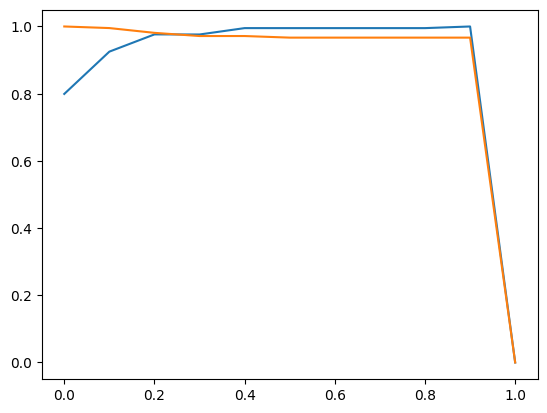

In [196]:
plt.plot(pr_df.index, pr_df['precision'])
plt.plot(pr_df.index, pr_df['recall'])

In [200]:
f1

[0.8884210526315789,
 0.958904109589041,
 0.9787234042553191,
 0.9738717339667459,
 0.9832134292565947,
 0.9807692307692307,
 0.9807692307692307,
 0.9807692307692307,
 0.9807692307692307,
 0.983132530120482,
 0.0]

In [209]:
def train(df, C):
    y_train = df['card'].values
    x_dict = df.drop('card', axis=1).to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(x_dict)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    x_dict = df.drop('card', axis=1).to_dict(orient='records')
    X = dv.transform(x_dict)
    y_true = df['card'].values
    y_pred = model.predict_proba(X)[:,1]
    
    return y_true, y_pred
    
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

C = [0.01, 0.1, 1, 10]

for C in C:
 
    score = []

    for train_idx, val_idx in kfold.split(fulltrain):
        train_df_cv = fulltrain.iloc[train_idx]
        val_df_cv = fulltrain.iloc[val_idx]

        dv, model = train(train_df_cv, C)
        y_true, y_pred = predict(val_df_cv, dv, model)

        auc = roc_auc_score(y_true, y_pred)
        score.append(auc)
        
    print(f'Mean Score : {np.mean(score)}, Std_dev : {np.std(score)}')
    
    
    

Mean Score : 0.9918810292344007, Std_dev : 0.00559887235402738
Mean Score : 0.9950557137157224, Std_dev : 0.003954138088244392
Mean Score : 0.9964498276814243, Std_dev : 0.0027434713804377724
Mean Score : 0.9963886109436032, Std_dev : 0.0028151486609295684


In [207]:
score

[0.9941860465116279,
 0.9941176470588236,
 0.9943346508563901,
 0.9996107939802803,
 1.0]

In [208]:
np.std(score)

0.0027434713804377724